# Manual Neural Netwok

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Operation():
    def __init__(self, input_nodes = []):
        self.input_nodes = input_nodes
        self.output_nodes = []
        for node in input_nodes:
            node.output_nodes.append(self) # operation should be outputted to all the output nodes of the node
        _default_graph.operations.append(self)
    
    def compute(self):
        pass # has to be overwritten

In [3]:
class add(Operation):
    def __init__(self, x, y):
        super().__init__([x, y])
    
    def compute(self, x_var, y_var):
        self.inputs = [x_var, y_var]
        return x_var + y_var

In [4]:
class multiply(Operation):
    def __init__(self, x, y):
        super().__init__([x, y])
    
    def compute(self, x_var, y_var):
        self.inputs = [x_var, y_var]
        return x_var * y_var

In [5]:
class matrixMultiply(Operation):
    def __init__(self, x, y):
        super().__init__([x, y])
    
    def compute(self, x_var, y_var):
        self.inputs = [x_var, y_var]
        return x_var.dot(y_var)

In [6]:
class PlaceHolder():
    def __init__(self):
        self.output_nodes = []
        _default_graph.placeholders.append(self)

In [7]:
class Variable(): # e.g. weight, bias
    def __init__(self, init_value = None):
        self.value = init_value
        self.output_nodes = []
        _default_graph.variables.append(self)

In [8]:
class Graph():
    def __init__(self):
        self.placeholders = []
        self.variables = []
        self.operations = []
        
    def set_as_default(self):
        global _default_graph
        _default_graph = self

In [9]:
def traverse_postorder(operation):
    # makes sure that the computations are done in the right order (ax first, then ax + b)
    # code is copied from the wiki page: https://en.wikipedia.org/wiki/Tree_traversal 
    # data structures skills have decreased over the years :')
    nodes_postorder = []
    def recurse(node):
        if isinstance(node, Operation):
            for input_node in node.input_nodes:
                recurse(input_node)
        nodes_postorder.append(node)
    recurse(operation)
    return nodes_postorder

In [10]:
class Session():
    def run(self, operation, feed_dict = {}):
        # feed_dict is going to be used to provide the batch of data
        nodes_postorder = traverse_postorder(operation)
        for node in nodes_postorder:
            if type(node) == PlaceHolder: # needs a data value
                node.output = feed_dict[node] # obtain it from the batch
            elif type(node) == Variable:
                node.output = node.value
            else: # operation
                # the input of an operation are the output nodes of each of it input nodes
                node.inputs = [input_node.output for input_node in node.input_nodes]
                node.output = node.compute(*node.inputs)
            if type(node.output) == list: #operation
                node.output = np.array(node.output) # convert to numpy array
        return operation.output

### Testing the operations in a session of the particular manual neural network

In [11]:
# addition operation
g = Graph()
g.set_as_default()
# z = ax + b, where z= output, a = 10 (weight), b = bias and x = the data value 
a = Variable(10)
b = Variable(1)
x = PlaceHolder()
y = multiply(a, x)
z = add(y, b)
sess = Session()
result = sess.run(operation = z, feed_dict = {x:10}) # 
result

101

In [12]:
# matrix multiplication operation
g = Graph()
g.set_as_default()
# z = a*x + b, where z= output, a = 10 (weight), b = bias and x = the data value 
a = Variable([[10, 20], [30, 40]])
b = Variable([1,2,])
x = PlaceHolder()
y = matrixMultiply(a, x)
z = add(y, b)
sess = Session()
result = sess.run(operation = z, feed_dict = {x:10}) # 
result

array([[101, 202],
       [301, 402]])

### Actual Classification using a real activation function

In [13]:
class Sigmoid(Operation):
    def __init__(self, z):
        super().__init__([z]) # only one parameter as input
    
    def compute(self, z_val):
         return 1 / (1 + np.exp(-z_val))

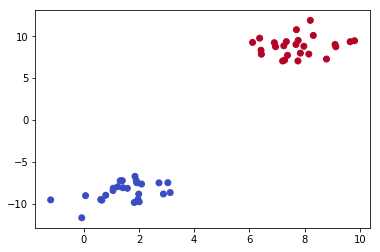

In [14]:
d = datasets.make_blobs(n_samples = 50, n_features = 2, centers = 2, random_state = 75)
# binary classification problem (2 blobs), based on 2 attributes
features = d[0] # d is a tuple
labels = d[1] 
plt.scatter(features[:,0], features[:,1], c = labels, cmap="coolwarm")

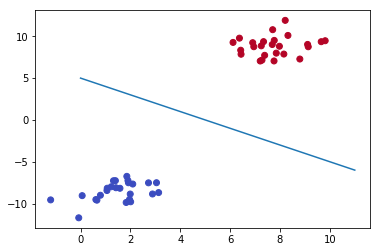

In [15]:
x = np.linspace(0, 11, 10)
y = -x + 5 # seems to do the job
plt.scatter(features[:,0], features[:,1], c = labels, cmap="coolwarm")
plt.plot(x, y)

to use the formula on a matrix (np array) of features (the features of the blobs) we need a matrix representation of the formula.
Note that it is basically feature2 = -1*feature1 + 5 and thus feature2 + feature1 - 5 = 0.
So.. featureMatrix (input blobs) * [1, 1] (matrix representation of formula) - 5 = 0

So below zero --> under the line, above zero --> above the line 

In [16]:
np.array([1,1]).dot(np.array([[8], [10]])) - 5

array([13])

In [17]:
g = Graph()
g.set_as_default()
x = PlaceHolder()
w = Variable([1, 1])
b = Variable(-5)
z = add(matrixMultiply(w, x), b)
a = Sigmoid(z)

The sigmoid function gives a result between 0 and 1
The more negative the result (z) is, the more sure the model will be about the fact that the particular feature-pair is 0 (belongs to the lower classification blob (cluster)
The more positive the result (x) is, the more the model will be about the fact that the particular feature-pair is 1 (belongs to the upper classification blob (cluster))
If it is close(r) to 0, the result is going to be (very) close to the line and thus we are less sure to which class the particular feauture pair (point) belongs to.

In [18]:
sess = Session()
sess.run(operation = a, feed_dict={x:[8,10]}) # so pretty sure that it belongs to upper class

0.99999773967570205

In [19]:
sess.run(operation = a, feed_dict={x:[1,-10]}) # cannot say a lot, very close to the line

8.3152802766413209e-07